# Remote Sensor Data Processing and Orthorectification

## Part 1: Background

## Introduction

The launch and deployment of high-resolution, high-revisit rate satellite image sensors has allowed humans unprecedented perspectives of the entire Earth at sub-meter and finer resolutions. These satellite photographers, like WorldView 2 and WorldView 3, among others, orbit the Earth heliosynchronously and take massive amounts of image data every day. 

The signal collected at the satellite sensor during image capture, however, is really most useful if we can map that data to an exact area on Earth that we can reference using familiar coordinate systems, expressed in longitude, latitude, and height. The mapping from the sample points on the sensor plate (image space) to world coordinates (lat, long, z), however, is not trivial to calculate. For instance, line-scanning photo-sensors collect light across the sensor plane non-simultaneously over some (small) time interval, meaning that neighboring pixels might be sampled from different physical reference frames. It's also often the case that a sensor collects Earth imagery from a non-zero azimuthal angle to the world target, meaning that the sensor samples the Earth from an angle, instead of looking "straight down." Left uncorrected, projecting this data onto a linear plane (like a map) will produce images with non-uniform distance scales, meaning that the real physical distance (on the Earth) between two points on the image separated by, say, ten pixels, will be different from the real physical distance between another set of points on the image separated by ten pixels. The inherent complexity of the non-inertial reference frame of the satellite/sensor's Earth-orbit, the geometry of the Earth itself, and the physical operating specifications of the photo-sensor all contribute to a number of image-artifacts which must be taken into account, corrected, and normalized before any quantitative measurements or calculations can be reliably made. To calculate a correct mapping, it's necessary to understand the physical properties of the sensor at time-of-capture, including orientation angle, etc, as well as the sensor optical specs. This information is provided via sensor models.


## The Image to World Space Mapping 


### What is a Sensor Model?


A sensor model is a description of the physical parameters of the actual camera sensor along with data acquisition specifications. Sensor models provide the information needed to determine the relationship between sample locations on the sensor (pixels) and coordinates on the Earth. Sensor models can be extremely complicated; they're also often unavailable to the public, as they contain proprietary technical information owned by the sensor manufacturer. Therefore, manufacturers often provide good approximations to the model via a set of Rational Polynomial Coefficients (RPCs) as metadata along with the delivered images. 


### Rational Polynomial Models
pass



## Orthorectification


### Digital Elevation Models (DEMs)

## Part 2: Application: Warping and Orthorectification using gbdxtools

The gbdxtools package provides a "warp" method on all image classes, which can be used to orthorectify a raw image. Generally, the interface provides a means to apply _any_ transformation to the input image. 

In the following, we'll orthorectify uncorrected images and inspect the effects. In the process, we'll learn how to:
   * How to search for and instantiate raw, uncorrected imagery
   * Instantiate DEM's for an AOI
   * Orthorectify raw images using the warp interface
   
We'll also investigate the variance in the effect of orthonormalization at different places on Earth. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['GBDX_THREADS'] = "32"
from gbdxtools import IdahoImage, CatalogImage, DemImage
from shapely.geometry import shape, box
import numpy as np
import datetime as dt

### CatalogImage to Raw IdahoImage

T

In [ ]:
catalog_id = '10400100171BAD00'
bbox = '-74.033260345459, 4.6909765724368215, -74.0138626098633, 4.709624736237738'

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=10, h=10)

Below, we grab the most recent IdahoImage that fully covers our aoi from the constituent parts of the CatalogImage. With the IdahoId, we can search for the raw, uncorrected image, orthorectify it, and compare.

In [ ]:
import datetime as dt
to_datetime = lambda x: dt.datetime.strptime(x.ipe.metadata['image']['acquisitionDate'], "%Y-%m-%dT%H:%M:%S.%fZ")

parts = image.parts
sbox = box(*image.bounds)
idahos = sorted([p for p in parts if shape(p).contains(sbox)], key=to_datetime, reverse=True)

Fetching Image... 36 tiles


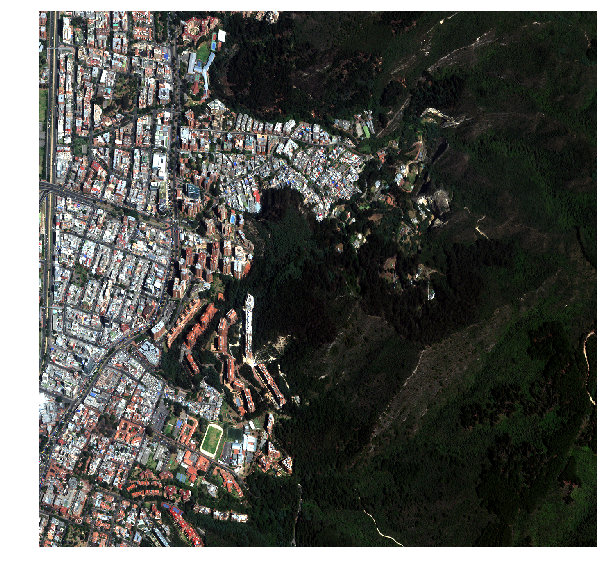

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ['GBDX_THREADS'] = "32"
from gbdxtools import IdahoImage, CatalogImage, TmsImage, DemImage
from shapely.geometry import shape, box, mapping
import numpy as np
import skimage.transform as tf

catalog_id = '10400100171BAD00'
bbox = '-74.033260345459, 4.6909765724368215, -74.0138626098633, 4.709624736237738'

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=10, h=10)

In [4]:
idaho = idahos[0]
idaho_raw = IdahoImage(idaho.ipe.metadata['image']['imageId'], product='1b')

In [5]:
raw_aoi = idaho_raw.aoi(bbox=image.bounds)

Fetching Image... 30 tiles


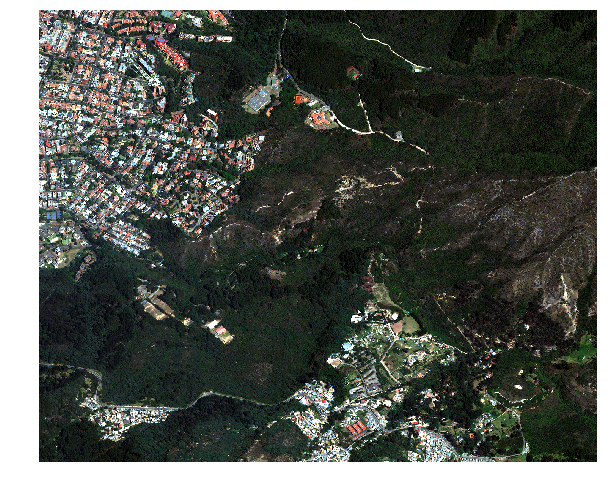

In [6]:
raw_aoi.plot(w=10, h=10)

In [20]:
#dem = DemImage(raw_aoi.bounds)
#dem = DemImage(idaho_raw.bounds)
#dem = 2640.0

In [6]:
dem = DemImage(raw_aoi.bounds)


In [29]:
xmin, ymin, xmax, ymax = raw_aoi.bounds
gsd = raw_aoi.ipe.metadata['rpcs']['gsd']
x = np.linspace(xmin, xmax, num=int((xmax-xmin)/gsd))
y = np.linspace(ymax, ymin, num=int((ymax-ymin)/gsd))
xv, yv = np.meshgrid(x, y, indexing='xy')

In [7]:
npdem = np.array(dem)

In [8]:
npdem[0,:,:]

array([[2561, 2562, 2562, ..., 2990, 2994, 2999],
       [2562, 2562, 2562, ..., 2999, 3003, 3007],
       [2564, 2563, 2562, ..., 3006, 3010, 3015],
       ..., 
       [2572, 2574, 2574, ..., 2939, 2942, 2949],
       [2572, 2573, 2575, ..., 2929, 2941, 2954],
       [2571, 2572, 2576, ..., 2929, 2946, 2961]], dtype=int16)

In [36]:
xv.shape, image.shape

((1286, 1337), (8, 1309, 1362))

In [10]:
npdem.shape

(1, 69, 71)

In [46]:
rsdem = tf.resize(npdem[0,:,:], xv.shape, preserve_range=True)

In [9]:
orthwdem = raw_aoi.warp(dem=npdem)

Fetching Image... 36 tiles


In [23]:
idaho_ipe = IdahoImage(idaho.ipe.metadata['image']['imageId'], band_type="MS", bbox=map(float, bbox.split(",")))

Fetching Image... 36 tiles
Request for https://idahoapi.geobigdata.io/v1/tile/idaho-virtual/8fb01bcd9369baca94b40841c701059c70186b24d12fa2b4610be19b208cde2e/00f92873-e423-5852-bf42-64cf77fc996b/27/13.tif returned unexpected error code: 502
<html>
<head><title>502 Bad Gateway</title></head>
<body bgcolor="white">
<center><h1>502 Bad Gateway</h1></center>
</body>
</html>

Request for https://idahoapi.geobigdata.io/v1/tile/idaho-virtual/8fb01bcd9369baca94b40841c701059c70186b24d12fa2b4610be19b208cde2e/00f92873-e423-5852-bf42-64cf77fc996b/25/14.tif returned unexpected error code: 502
<html>
<head><title>502 Bad Gateway</title></head>
<body bgcolor="white">
<center><h1>502 Bad Gateway</h1></center>
</body>
</html>

Request for https://idahoapi.geobigdata.io/v1/tile/idaho-virtual/8fb01bcd9369baca94b40841c701059c70186b24d12fa2b4610be19b208cde2e/00f92873-e423-5852-bf42-64cf77fc996b/30/15.tif returned unexpected error code: 502
<html>
<head><title>502 Bad Gateway</title></head>
<body bgcolor="wh

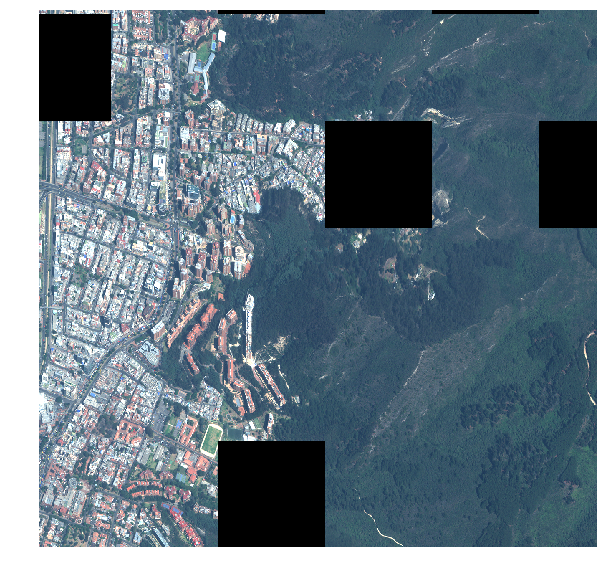

In [24]:
idaho_ipe.plot(w=10, h=10)

In [25]:
idaho_ipe.shape

(8, 1286, 1337)

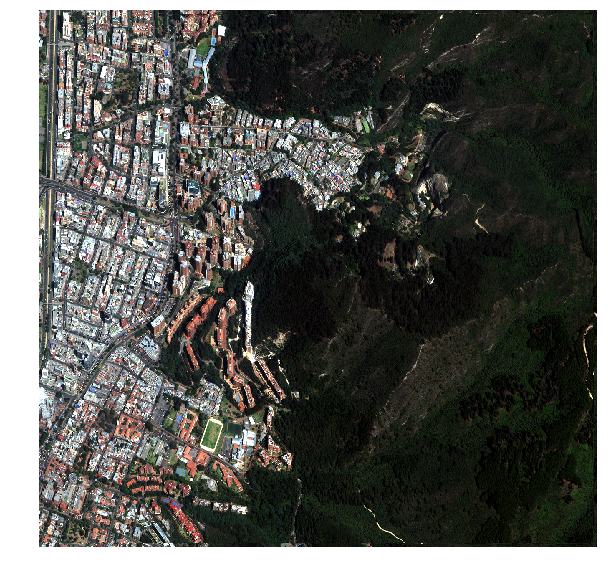

In [10]:
orthwdem.plot(w=10, h=10)

In [15]:
raw_aoi.ipe.metadata

{'georef': None,
 'image': {u'acquisitionDate': u'2016-01-19T15:37:34.195Z',
  u'cloudCover': 0.011,
  u'colorInterpretation': u'WORLDVIEW_8_BAND',
  u'dataType': u'UNSIGNED_SHORT',
  u'groundSampleDistanceMeters': 1.614,
  u'imageBoundsWGS84': u'POLYGON ((-74.12725589 4.76146917, -73.98710248 4.75684129, -73.9872462 4.62931691, -74.12704981 4.63656974, -74.12725589 4.76146917))',
  u'imageHeight': 7796,
  u'imageId': u'9361fc6a-f9a5-49a0-b36e-ba46aac2cbab',
  u'imageWidth': 10651,
  u'maxTileX': 41,
  u'maxTileY': 30,
  u'maxX': 10650,
  u'maxY': 7795,
  u'minTileX': 0,
  u'minTileY': 0,
  u'minX': 0,
  u'minY': 0,
  u'numBands': 8,
  u'numXTiles': 42,
  u'numYTiles': 31,
  u'offNadirAngle': 31.2,
  u'pniirs': 3.3,
  u'profileName': u'dg_1b',
  u'satAzimuth': 177.7,
  u'satElevation': 55.4,
  u'sensorName': u'8-band (Coastal, Blue, Green, Yellow, Red, Red-edge, NIR1, NIR2) Multispectral',
  u'sensorPlatformName': u'WV03',
  u'sunAzimuth': 139.6,
  u'sunElevation': 56.7,
  u'tilePartit

In [17]:
raw_aoi.shape

(8, 1190, 1471)

In [19]:
image.proj

u'EPSG:4326'

In [26]:
orthwdem.shape

(8, 1286, 1337)

In [18]:
#orthod = raw_aoi.warp(dem=np.array(dem))
orthod = raw_aoi.warp(dem=dem)

Fetching Image... 30 tiles


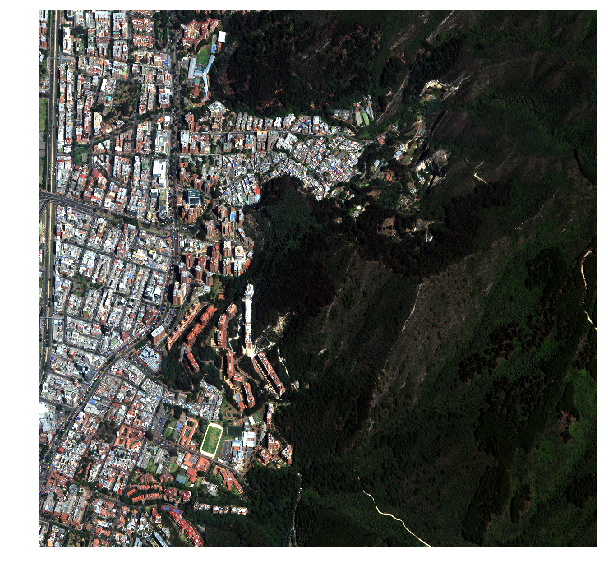

In [19]:
orthod.plot(w=10, h=10)

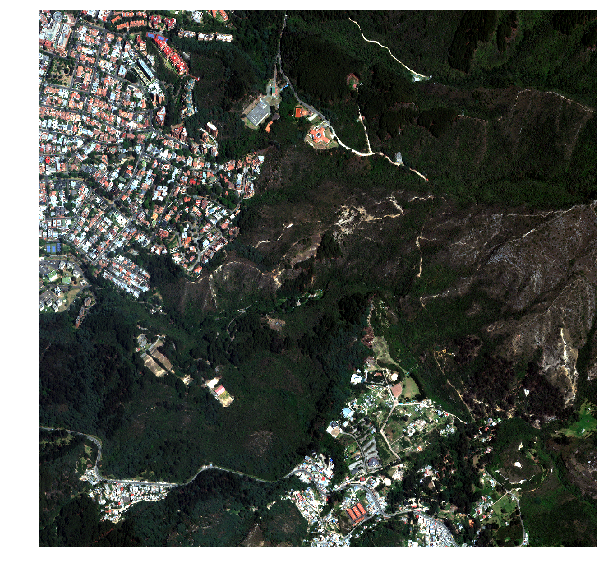

In [15]:
orthod.plot(w=10, h=10)

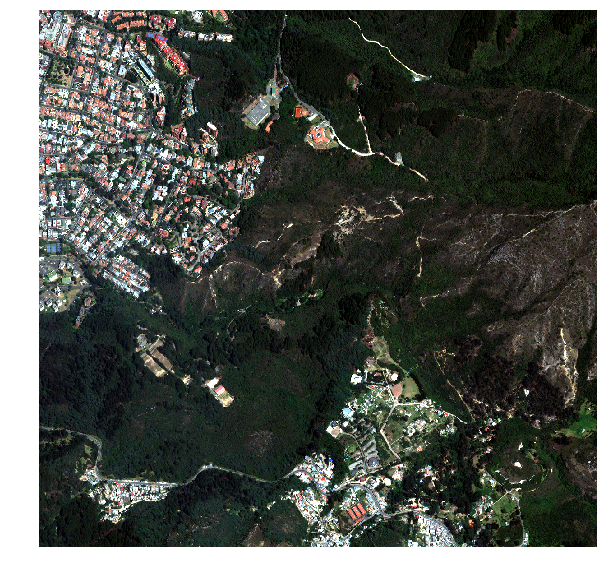

In [11]:
orthod.plot(w=10, h=10)

In [12]:
orthod.shape, image.shape

((8, 1190, 1237), (8, 1309, 1362))